不動産価格予測

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"

%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


In [3]:
# zipファイルの解凍

# 古いdata.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

In [4]:
# train.zipの解凍
# 古いtrain.zipの削除
!rm -r /content/drive/MyDrive/property_values_prediction/data/train

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

!rm -r /content/drive/MyDrive/property_values_prediction/data/__MACOSX

rm: cannot remove '/content/drive/MyDrive/property_values_prediction/data/train': No such file or directory


In [5]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [6]:
!pip install optuna xfeat japanize-matplotlib catboost==0.26 >> /dev/null

In [7]:
import re

import japanize_matplotlib
import catboost as cb
from catboost import CatBoost, Pool
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(
    action="ignore", category=pd.core.common.SettingWithCopyWarning
)

In [8]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


In [9]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [10]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [12]:
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [13]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

In [14]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [15]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [16]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [17]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [18]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [19]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [20]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [21]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,27232131,大阪府,大阪市旭区,新森,森小路,6,１ＬＤＫ,50,昭和49年,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,2005年第３四半期,改装済,NaN,7.041393,0,0.0
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7,３ＬＤＫ,60,平成4年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2005年第３四半期,改装済,NaN,7.361728,0,0.0


In [22]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [23]:
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [24]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [25]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [26]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0


In [27]:
feat_df = pd.concat([num_df,le_df,num_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 38)


In [28]:
feat_df.dtypes

ID                                   int64
最寄駅：距離（分）                          float64
面積（㎡）                                int64
建築年                                float64
建ぺい率（％）                            float64
容積率（％）                             float64
取引価格（総額）_log                       float64
取引時点_enc                             int64
都道府県名_te                           float64
取引時点_何年前                             int64
都道府県名                                int64
市区町村名                                int64
地区名                                  int64
最寄駅：名称                               int64
間取り                                  int64
建物の構造                                int64
用途                                   int64
今後の利用目的                              int64
都市計画                                 int64
改装                                   int64
取引の事情等                               int64
面積（㎡）容積率（％）_combi                  float64
agg_count_最寄駅：距離（分）_grpby_市区町村名      int64
agg_count_面

In [29]:
# カーネルが落ちるため、float32へ変換する
# trans_cols_float32 = ["最寄駅：距離（分）",
#                       "建築年", "建ぺい率（％）",
#                       "容積率（％）", "都道府県名_te",
#                       "面積（㎡）容積率（％）_combi",
#                       "agg_mean_最寄駅：距離（分）_grpby_市区町村名",
#                       "agg_mean_面積（㎡）_grpby_市区町村名",
#                       "agg_mean_建ぺい率（％）_grpby_市区町村名",
#                       "agg_mean_容積率（％）_grpby_市区町村名",
#                       "agg_min_最寄駅：距離（分）_grpby_市区町村名",
#                       "agg_min_建ぺい率（％）_grpby_市区町村名",
#                       "agg_min_容積率（％）_grpby_市区町村名",
#                       "agg_max_最寄駅：距離（分）_grpby_市区町村名",
#                       "agg_max_建ぺい率（％）_grpby_市区町村名",
#                       "agg_max_容積率（％）_grpby_市区町村名",
#                       "取引価格（総額）_log",
#                       ]

# feat_df[trans_cols_float32] = feat_df[trans_cols_float32].astype("float32")
# feat_df.dtypes

モデル構築

In [30]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 38) (24899, 38) (23151, 38)


In [31]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [32]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [33]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [36]:
def objective(trial):

    param = {
        "iterations": 3000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.01, 100.00
        ),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "task_type": "GPU",
    }

    model = cb.CatBoostRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=100,
        verbose_eval=500,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [37]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50)

[I 2021-11-29 07:10:01,284] A new study created in memory with name: no-name-36a66ca2-c57e-4500-9772-549317628f16
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.3521001	test: 0.3609609	best: 0.3609609 (0)	total: 40.9ms	remaining: 2m 2s
100:	learn: 0.2354116	test: 0.2453064	best: 0.2453064 (100)	total: 3.07s	remaining: 1m 28s
200:	learn: 0.1975073	test: 0.2069281	best: 0.2069281 (200)	total: 5.83s	remaining: 1m 21s
300:	learn: 0.1822347	test: 0.1911865	best: 0.1911865 (300)	total: 8.55s	remaining: 1m 16s
400:	learn: 0.1738739	test: 0.1824887	best: 0.1824887 (400)	total: 11.3s	remaining: 1m 13s
500:	learn: 0.1686129	test: 0.1767768	best: 0.1767768 (500)	total: 13.9s	remaining: 1m 9s
600:	learn: 0.1650122	test: 0.1727014	best: 0.1727014 (600)	total: 16.6s	remaining: 1m 6s
700:	learn: 0.1618164	test: 0.1691528	best: 0.1691528 (700)	total: 19.3s	remaining: 1m 3s
800:	learn: 0.1597401	test: 0.1667795	best: 0.1667795 (800)	total: 21.9s	remaining: 1m
900:	learn: 0.1578941	test: 0.1646484	best: 0.1646484 (900)	total: 24.5s	remaining: 57.1s
1000:	learn: 0.1563083	test: 0.1627796	best: 0.1627796 (1000)	total: 27.2s	remaining: 54.2s
1100:	lear

[I 2021-11-29 07:11:25,468] Trial 0 finished with value: 0.09518867508245729 and parameters: {'depth': 9, 'learning_rate': 0.010731320001845925, 'random_strength': 63, 'bagging_temperature': 9.890438121030062, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 0 with value: 0.09518867508245729.


0:	learn: 0.3504960	test: 0.3593763	best: 0.3593763 (0)	total: 32.5ms	remaining: 1m 37s
100:	learn: 0.1929683	test: 0.2054284	best: 0.2054284 (100)	total: 2.92s	remaining: 1m 23s
200:	learn: 0.1690484	test: 0.1787406	best: 0.1787406 (200)	total: 5.66s	remaining: 1m 18s
300:	learn: 0.1614733	test: 0.1697180	best: 0.1697180 (300)	total: 8.39s	remaining: 1m 15s
400:	learn: 0.1569541	test: 0.1640925	best: 0.1640925 (400)	total: 11.1s	remaining: 1m 11s
500:	learn: 0.1540391	test: 0.1604529	best: 0.1604529 (500)	total: 13.7s	remaining: 1m 8s
600:	learn: 0.1516157	test: 0.1575227	best: 0.1575227 (600)	total: 16.3s	remaining: 1m 5s
700:	learn: 0.1496394	test: 0.1552232	best: 0.1552232 (700)	total: 19s	remaining: 1m 2s
800:	learn: 0.1478423	test: 0.1532399	best: 0.1532399 (800)	total: 21.7s	remaining: 59.5s
900:	learn: 0.1463031	test: 0.1516565	best: 0.1516565 (900)	total: 24.3s	remaining: 56.6s
1000:	learn: 0.1450343	test: 0.1504374	best: 0.1504374 (1000)	total: 26.9s	remaining: 53.7s
1100:	le

[I 2021-11-29 07:12:51,962] Trial 1 finished with value: 0.09093833166628555 and parameters: {'depth': 9, 'learning_rate': 0.017774492563555844, 'random_strength': 8, 'bagging_temperature': 5.513651007120872, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 1 with value: 0.09093833166628555.


0:	learn: 0.3385362	test: 0.3481105	best: 0.3481105 (0)	total: 31.9ms	remaining: 1m 35s
100:	learn: 0.1611127	test: 0.1680673	best: 0.1680673 (100)	total: 2.69s	remaining: 1m 17s
200:	learn: 0.1502509	test: 0.1556876	best: 0.1556876 (200)	total: 5.32s	remaining: 1m 14s
300:	learn: 0.1439164	test: 0.1494071	best: 0.1494071 (300)	total: 7.96s	remaining: 1m 11s
400:	learn: 0.1413543	test: 0.1470477	best: 0.1470477 (400)	total: 10.5s	remaining: 1m 8s
500:	learn: 0.1389623	test: 0.1450552	best: 0.1450552 (500)	total: 13.3s	remaining: 1m 6s
600:	learn: 0.1372793	test: 0.1436951	best: 0.1436951 (600)	total: 16.1s	remaining: 1m 4s
700:	learn: 0.1362083	test: 0.1431659	best: 0.1431659 (700)	total: 18.9s	remaining: 1m 2s
800:	learn: 0.1350924	test: 0.1424491	best: 0.1424491 (800)	total: 21.7s	remaining: 59.7s
900:	learn: 0.1343119	test: 0.1419643	best: 0.1419598 (899)	total: 24.6s	remaining: 57.3s
1000:	learn: 0.1334608	test: 0.1415036	best: 0.1415036 (1000)	total: 27.5s	remaining: 54.9s
1100:	l

[I 2021-11-29 07:13:44,273] Trial 2 finished with value: 0.0894396739980726 and parameters: {'depth': 9, 'learning_rate': 0.0803110441567395, 'random_strength': 72, 'bagging_temperature': 0.14706328837360433, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3493998	test: 0.3580679	best: 0.3580679 (0)	total: 20.3ms	remaining: 1m
100:	learn: 0.2046188	test: 0.2153885	best: 0.2153885 (100)	total: 1.3s	remaining: 37.4s
200:	learn: 0.1835222	test: 0.1925003	best: 0.1925003 (200)	total: 2.54s	remaining: 35.3s
300:	learn: 0.1764729	test: 0.1850743	best: 0.1850743 (300)	total: 3.75s	remaining: 33.7s
400:	learn: 0.1715009	test: 0.1794279	best: 0.1794279 (400)	total: 4.97s	remaining: 32.2s
500:	learn: 0.1656392	test: 0.1726167	best: 0.1726167 (500)	total: 6.21s	remaining: 31s
600:	learn: 0.1618349	test: 0.1685854	best: 0.1685854 (600)	total: 7.45s	remaining: 29.7s
700:	learn: 0.1592376	test: 0.1657638	best: 0.1657638 (700)	total: 8.67s	remaining: 28.4s
800:	learn: 0.1574216	test: 0.1638601	best: 0.1638601 (800)	total: 9.91s	remaining: 27.2s
900:	learn: 0.1559569	test: 0.1620825	best: 0.1620825 (900)	total: 11.2s	remaining: 26s
1000:	learn: 0.1555947	test: 0.1616343	best: 0.1616343 (1000)	total: 12.3s	remaining: 24.6s
1100:	learn: 0.1555

[I 2021-11-29 07:14:03,994] Trial 3 finished with value: 0.10860516401843921 and parameters: {'depth': 4, 'learning_rate': 0.03560160455275411, 'random_strength': 68, 'bagging_temperature': 0.5852382428491513, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3393090	test: 0.3486043	best: 0.3486043 (0)	total: 27.4ms	remaining: 1m 22s
100:	learn: 0.1656593	test: 0.1726337	best: 0.1726337 (100)	total: 2.36s	remaining: 1m 7s
200:	learn: 0.1553935	test: 0.1612134	best: 0.1612134 (200)	total: 4.62s	remaining: 1m 4s
300:	learn: 0.1469967	test: 0.1519581	best: 0.1519581 (300)	total: 6.93s	remaining: 1m 2s
400:	learn: 0.1439143	test: 0.1490128	best: 0.1490128 (400)	total: 9.21s	remaining: 59.7s
500:	learn: 0.1424920	test: 0.1475602	best: 0.1475602 (500)	total: 11.4s	remaining: 56.9s
600:	learn: 0.1413706	test: 0.1465901	best: 0.1465901 (600)	total: 13.7s	remaining: 54.7s
700:	learn: 0.1404934	test: 0.1457766	best: 0.1457758 (699)	total: 16.1s	remaining: 52.6s
800:	learn: 0.1404410	test: 0.1457512	best: 0.1457281 (703)	total: 18.4s	remaining: 50.5s
bestTest = 0.1457280609
bestIteration = 703
Shrink model to first 704 iterations.


[I 2021-11-29 07:14:25,210] Trial 4 finished with value: 0.09472955066797913 and parameters: {'depth': 8, 'learning_rate': 0.0772338017410434, 'random_strength': 81, 'bagging_temperature': 1.2206428444236328, 'od_type': 'IncToDec', 'od_wait': 13}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3515931	test: 0.3603770	best: 0.3603770 (0)	total: 22.8ms	remaining: 1m 8s
100:	learn: 0.2346613	test: 0.2436286	best: 0.2436286 (100)	total: 1.87s	remaining: 53.6s
200:	learn: 0.2012591	test: 0.2102691	best: 0.2102691 (200)	total: 3.65s	remaining: 50.8s
300:	learn: 0.1869220	test: 0.1957600	best: 0.1957600 (300)	total: 5.4s	remaining: 48.5s
400:	learn: 0.1794353	test: 0.1880949	best: 0.1880949 (400)	total: 7.18s	remaining: 46.5s
500:	learn: 0.1744528	test: 0.1825448	best: 0.1825448 (500)	total: 8.9s	remaining: 44.4s
600:	learn: 0.1713131	test: 0.1792412	best: 0.1792412 (600)	total: 10.6s	remaining: 42.3s
700:	learn: 0.1687622	test: 0.1765068	best: 0.1765068 (700)	total: 12.3s	remaining: 40.4s
800:	learn: 0.1667876	test: 0.1742455	best: 0.1742455 (800)	total: 14s	remaining: 38.4s
900:	learn: 0.1648215	test: 0.1719091	best: 0.1719091 (900)	total: 15.7s	remaining: 36.6s
1000:	learn: 0.1627310	test: 0.1694458	best: 0.1694458 (1000)	total: 17.5s	remaining: 34.9s
1100:	learn: 0.

[I 2021-11-29 07:15:20,418] Trial 5 finished with value: 0.10267886211628295 and parameters: {'depth': 6, 'learning_rate': 0.014735630523036643, 'random_strength': 83, 'bagging_temperature': 0.015402289339220209, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3200642	test: 0.3302853	best: 0.3302853 (0)	total: 17.2ms	remaining: 51.4s
100:	learn: 0.1591748	test: 0.1654168	best: 0.1654168 (100)	total: 1.49s	remaining: 42.9s
200:	learn: 0.1508755	test: 0.1565816	best: 0.1565816 (200)	total: 2.95s	remaining: 41s
300:	learn: 0.1502739	test: 0.1556934	best: 0.1556614 (267)	total: 4.27s	remaining: 38.3s
bestTest = 0.1556613928
bestIteration = 267
Shrink model to first 268 iterations.


[I 2021-11-29 07:15:27,974] Trial 6 finished with value: 0.10304029846683332 and parameters: {'depth': 5, 'learning_rate': 0.18436216261768837, 'random_strength': 35, 'bagging_temperature': 10.437362473807193, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3467687	test: 0.3557782	best: 0.3557782 (0)	total: 16.8ms	remaining: 50.3s
100:	learn: 0.1823666	test: 0.1934946	best: 0.1934946 (100)	total: 1.57s	remaining: 45s
200:	learn: 0.1696264	test: 0.1783927	best: 0.1783927 (200)	total: 3.03s	remaining: 42.2s
300:	learn: 0.1644259	test: 0.1720227	best: 0.1720227 (300)	total: 4.51s	remaining: 40.4s
400:	learn: 0.1602236	test: 0.1667988	best: 0.1667988 (400)	total: 5.98s	remaining: 38.7s
500:	learn: 0.1561782	test: 0.1622639	best: 0.1622639 (500)	total: 7.47s	remaining: 37.3s
600:	learn: 0.1537172	test: 0.1595545	best: 0.1595545 (600)	total: 8.96s	remaining: 35.8s
700:	learn: 0.1521401	test: 0.1578943	best: 0.1578943 (700)	total: 10.4s	remaining: 34.1s
800:	learn: 0.1516384	test: 0.1573934	best: 0.1573934 (800)	total: 11.8s	remaining: 32.5s
900:	learn: 0.1515107	test: 0.1572369	best: 0.1572369 (900)	total: 13.3s	remaining: 30.9s
1000:	learn: 0.1510776	test: 0.1566854	best: 0.1566854 (1000)	total: 14.7s	remaining: 29.3s
1100:	learn: 

[I 2021-11-29 07:15:59,508] Trial 7 finished with value: 0.10105583567248227 and parameters: {'depth': 5, 'learning_rate': 0.03800259814899221, 'random_strength': 9, 'bagging_temperature': 19.249640862099252, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 2 with value: 0.0894396739980726.


0:	learn: 0.3441940	test: 0.3536726	best: 0.3536726 (0)	total: 37ms	remaining: 1m 50s
100:	learn: 0.1691354	test: 0.1770384	best: 0.1770384 (100)	total: 3.26s	remaining: 1m 33s
200:	learn: 0.1552067	test: 0.1620078	best: 0.1620078 (200)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.1497633	test: 0.1557326	best: 0.1557326 (300)	total: 9.45s	remaining: 1m 24s
400:	learn: 0.1442340	test: 0.1496992	best: 0.1496992 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1407579	test: 0.1464312	best: 0.1464312 (500)	total: 15.8s	remaining: 1m 18s
600:	learn: 0.1385272	test: 0.1445411	best: 0.1445411 (600)	total: 18.9s	remaining: 1m 15s
700:	learn: 0.1366261	test: 0.1431608	best: 0.1431608 (700)	total: 22.2s	remaining: 1m 12s
800:	learn: 0.1350643	test: 0.1420623	best: 0.1420623 (800)	total: 25.5s	remaining: 1m 9s
900:	learn: 0.1335666	test: 0.1411673	best: 0.1411673 (900)	total: 28.8s	remaining: 1m 7s
1000:	learn: 0.1324142	test: 0.1405691	best: 0.1405691 (1000)	total: 32.2s	remaining: 1m 4s
1100:

[I 2021-11-29 07:17:29,077] Trial 8 finished with value: 0.08661287717129645 and parameters: {'depth': 10, 'learning_rate': 0.04720816778029152, 'random_strength': 83, 'bagging_temperature': 0.10127366729692723, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3518588	test: 0.3606787	best: 0.3606787 (0)	total: 27.2ms	remaining: 1m 21s
100:	learn: 0.2303298	test: 0.2411373	best: 0.2411373 (100)	total: 2.5s	remaining: 1m 11s
200:	learn: 0.1944165	test: 0.2050788	best: 0.2050788 (200)	total: 4.93s	remaining: 1m 8s
300:	learn: 0.1801945	test: 0.1899659	best: 0.1899659 (300)	total: 7.24s	remaining: 1m 4s
400:	learn: 0.1726177	test: 0.1816433	best: 0.1816433 (400)	total: 9.55s	remaining: 1m 1s
500:	learn: 0.1678550	test: 0.1763654	best: 0.1763654 (500)	total: 11.8s	remaining: 59s
600:	learn: 0.1647871	test: 0.1729059	best: 0.1729059 (600)	total: 14.1s	remaining: 56.2s
700:	learn: 0.1622346	test: 0.1697142	best: 0.1697142 (700)	total: 16.4s	remaining: 53.8s
800:	learn: 0.1601482	test: 0.1673041	best: 0.1673041 (800)	total: 18.7s	remaining: 51.3s
900:	learn: 0.1585034	test: 0.1654001	best: 0.1654001 (900)	total: 20.9s	remaining: 48.8s
1000:	learn: 0.1571319	test: 0.1636849	best: 0.1636849 (1000)	total: 23.2s	remaining: 46.4s
1100:	learn:

[I 2021-11-29 07:18:41,566] Trial 9 finished with value: 0.09704582608357501 and parameters: {'depth': 8, 'learning_rate': 0.01142941318767822, 'random_strength': 36, 'bagging_temperature': 0.020818640252904794, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.2983464	test: 0.3097627	best: 0.3097627 (0)	total: 38.5ms	remaining: 1m 55s
100:	learn: 0.1403153	test: 0.1465568	best: 0.1465568 (100)	total: 3.18s	remaining: 1m 31s
200:	learn: 0.1323961	test: 0.1416050	best: 0.1416050 (200)	total: 6.44s	remaining: 1m 29s
300:	learn: 0.1276298	test: 0.1392257	best: 0.1392257 (300)	total: 9.7s	remaining: 1m 26s
400:	learn: 0.1245421	test: 0.1385582	best: 0.1385582 (400)	total: 13.2s	remaining: 1m 25s
500:	learn: 0.1228045	test: 0.1383364	best: 0.1383045 (470)	total: 16.7s	remaining: 1m 23s
bestTest = 0.1383044951
bestIteration = 470
Shrink model to first 471 iterations.


[I 2021-11-29 07:19:03,322] Trial 10 finished with value: 0.08887118900109485 and parameters: {'depth': 10, 'learning_rate': 0.27751325657892656, 'random_strength': 99, 'bagging_temperature': 0.14127491355640354, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3100350	test: 0.3208942	best: 0.3208942 (0)	total: 38ms	remaining: 1m 53s
100:	learn: 0.1435999	test: 0.1495149	best: 0.1495149 (100)	total: 3.17s	remaining: 1m 31s
200:	learn: 0.1353651	test: 0.1437371	best: 0.1437371 (200)	total: 6.51s	remaining: 1m 30s
300:	learn: 0.1316654	test: 0.1425350	best: 0.1425344 (289)	total: 9.95s	remaining: 1m 29s
400:	learn: 0.1285133	test: 0.1411427	best: 0.1411427 (400)	total: 13.4s	remaining: 1m 26s
500:	learn: 0.1253843	test: 0.1399646	best: 0.1399646 (500)	total: 16.8s	remaining: 1m 23s
600:	learn: 0.1229317	test: 0.1388305	best: 0.1388305 (600)	total: 20.2s	remaining: 1m 20s
700:	learn: 0.1211762	test: 0.1383791	best: 0.1383663 (697)	total: 23.6s	remaining: 1m 17s
800:	learn: 0.1195141	test: 0.1381930	best: 0.1381505 (796)	total: 27s	remaining: 1m 14s
900:	learn: 0.1185078	test: 0.1380889	best: 0.1380889 (899)	total: 30.5s	remaining: 1m 11s
1000:	learn: 0.1185078	test: 0.1380890	best: 0.1380889 (901)	total: 34.1s	remaining: 1m 8s
bestTe

[I 2021-11-29 07:19:40,557] Trial 11 finished with value: 0.08749634298885912 and parameters: {'depth': 10, 'learning_rate': 0.2156917030647058, 'random_strength': 99, 'bagging_temperature': 0.09532980882889507, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3203681	test: 0.3307319	best: 0.3307319 (0)	total: 38.6ms	remaining: 1m 55s
100:	learn: 0.1494148	test: 0.1548007	best: 0.1548007 (100)	total: 3.15s	remaining: 1m 30s
200:	learn: 0.1377659	test: 0.1444882	best: 0.1444882 (200)	total: 6.32s	remaining: 1m 28s
300:	learn: 0.1340881	test: 0.1423548	best: 0.1423548 (300)	total: 9.65s	remaining: 1m 26s
400:	learn: 0.1332069	test: 0.1418093	best: 0.1417922 (357)	total: 13.1s	remaining: 1m 24s
bestTest = 0.1417922002
bestIteration = 357
Shrink model to first 358 iterations.


[I 2021-11-29 07:19:58,039] Trial 12 finished with value: 0.09142426740521635 and parameters: {'depth': 10, 'learning_rate': 0.1630414273606531, 'random_strength': 100, 'bagging_temperature': 0.08664527597771104, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3367258	test: 0.3455793	best: 0.3455793 (0)	total: 24.5ms	remaining: 1m 13s
100:	learn: 0.1639636	test: 0.1704728	best: 0.1704728 (100)	total: 2.07s	remaining: 59.4s
200:	learn: 0.1510251	test: 0.1559763	best: 0.1559763 (200)	total: 4.13s	remaining: 57.5s
300:	learn: 0.1472450	test: 0.1524421	best: 0.1524421 (300)	total: 6.1s	remaining: 54.7s
400:	learn: 0.1456613	test: 0.1508496	best: 0.1508496 (400)	total: 8.05s	remaining: 52.2s
500:	learn: 0.1452892	test: 0.1504907	best: 0.1504577 (452)	total: 10.1s	remaining: 50.3s
bestTest = 0.1504576611
bestIteration = 452
Shrink model to first 453 iterations.


[I 2021-11-29 07:20:11,682] Trial 13 finished with value: 0.0987538268243755 and parameters: {'depth': 7, 'learning_rate': 0.106067586038296, 'random_strength': 89, 'bagging_temperature': 0.7457334889148345, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3456941	test: 0.3550632	best: 0.3550632 (0)	total: 36.8ms	remaining: 1m 50s
100:	learn: 0.1709230	test: 0.1794760	best: 0.1794760 (100)	total: 3.28s	remaining: 1m 34s
200:	learn: 0.1571272	test: 0.1638969	best: 0.1638969 (200)	total: 6.39s	remaining: 1m 29s
300:	learn: 0.1514879	test: 0.1575907	best: 0.1575907 (300)	total: 9.44s	remaining: 1m 24s
400:	learn: 0.1471022	test: 0.1526839	best: 0.1526839 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1432485	test: 0.1490282	best: 0.1490282 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1408330	test: 0.1469460	best: 0.1469460 (600)	total: 18.8s	remaining: 1m 15s
700:	learn: 0.1389137	test: 0.1452273	best: 0.1452273 (700)	total: 22s	remaining: 1m 12s
800:	learn: 0.1372541	test: 0.1439673	best: 0.1439673 (800)	total: 25.3s	remaining: 1m 9s
900:	learn: 0.1358272	test: 0.1428843	best: 0.1428843 (900)	total: 28.6s	remaining: 1m 6s
1000:	learn: 0.1345958	test: 0.1421176	best: 0.1421176 (1000)	total: 31.9s	remaining: 1m 3s
1100:

[I 2021-11-29 07:21:23,384] Trial 14 finished with value: 0.08786603561440008 and parameters: {'depth': 10, 'learning_rate': 0.040093020617237574, 'random_strength': 52, 'bagging_temperature': 0.04843247947449525, 'od_type': 'Iter', 'od_wait': 11}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3502244	test: 0.3590197	best: 0.3590197 (0)	total: 27.7ms	remaining: 1m 23s
100:	learn: 0.2000872	test: 0.2092749	best: 0.2092749 (100)	total: 2.48s	remaining: 1m 11s
200:	learn: 0.1775016	test: 0.1856294	best: 0.1856294 (200)	total: 4.79s	remaining: 1m 6s
300:	learn: 0.1682466	test: 0.1758945	best: 0.1758945 (300)	total: 7.05s	remaining: 1m 3s
400:	learn: 0.1628272	test: 0.1700740	best: 0.1700740 (400)	total: 9.3s	remaining: 1m
500:	learn: 0.1592744	test: 0.1660338	best: 0.1660338 (500)	total: 11.6s	remaining: 57.8s
600:	learn: 0.1566954	test: 0.1629896	best: 0.1629896 (600)	total: 13.9s	remaining: 55.4s
700:	learn: 0.1532677	test: 0.1587253	best: 0.1587253 (700)	total: 16.2s	remaining: 53.2s
800:	learn: 0.1503054	test: 0.1555681	best: 0.1555681 (800)	total: 18.5s	remaining: 50.9s
900:	learn: 0.1480877	test: 0.1533832	best: 0.1533832 (900)	total: 20.8s	remaining: 48.5s
1000:	learn: 0.1466407	test: 0.1518464	best: 0.1518464 (1000)	total: 23.1s	remaining: 46.2s
1100:	learn: 

[I 2021-11-29 07:22:37,205] Trial 15 finished with value: 0.09316775534804267 and parameters: {'depth': 8, 'learning_rate': 0.023407828759910754, 'random_strength': 89, 'bagging_temperature': 89.89652478139105, 'od_type': 'Iter', 'od_wait': 29}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3400579	test: 0.3498393	best: 0.3498393 (0)	total: 36.9ms	remaining: 1m 50s
100:	learn: 0.1601323	test: 0.1675500	best: 0.1675500 (100)	total: 3.22s	remaining: 1m 32s
200:	learn: 0.1497486	test: 0.1560945	best: 0.1560945 (200)	total: 6.29s	remaining: 1m 27s
300:	learn: 0.1429633	test: 0.1490881	best: 0.1490881 (300)	total: 9.39s	remaining: 1m 24s
400:	learn: 0.1387737	test: 0.1454030	best: 0.1454030 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1363677	test: 0.1435178	best: 0.1435178 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1341322	test: 0.1420358	best: 0.1420358 (600)	total: 19.1s	remaining: 1m 16s
700:	learn: 0.1323902	test: 0.1410353	best: 0.1410353 (700)	total: 22.4s	remaining: 1m 13s
800:	learn: 0.1309817	test: 0.1402116	best: 0.1402116 (800)	total: 25.8s	remaining: 1m 10s
900:	learn: 0.1298103	test: 0.1396439	best: 0.1396439 (900)	total: 29.2s	remaining: 1m 7s
1000:	learn: 0.1289460	test: 0.1394143	best: 0.1394143 (1000)	total: 32.5s	remaining: 1m 4s
11

[I 2021-11-29 07:23:23,489] Trial 16 finished with value: 0.08807642266524011 and parameters: {'depth': 10, 'learning_rate': 0.06694057102711598, 'random_strength': 54, 'bagging_temperature': 0.34045689478066676, 'od_type': 'Iter', 'od_wait': 38}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3299197	test: 0.3392305	best: 0.3392305 (0)	total: 24.8ms	remaining: 1m 14s
100:	learn: 0.1600678	test: 0.1661556	best: 0.1661556 (100)	total: 2.05s	remaining: 58.8s
200:	learn: 0.1487006	test: 0.1536348	best: 0.1536348 (200)	total: 4.07s	remaining: 56.7s
300:	learn: 0.1454927	test: 0.1506110	best: 0.1506110 (300)	total: 6.04s	remaining: 54.1s
400:	learn: 0.1439182	test: 0.1493495	best: 0.1493495 (400)	total: 8.04s	remaining: 52.1s
500:	learn: 0.1430439	test: 0.1485854	best: 0.1485854 (500)	total: 10.1s	remaining: 50.2s
600:	learn: 0.1429353	test: 0.1485075	best: 0.1484912 (508)	total: 12s	remaining: 48s
bestTest = 0.1484911693
bestIteration = 508
Shrink model to first 509 iterations.


[I 2021-11-29 07:23:38,136] Trial 17 finished with value: 0.09679420823912023 and parameters: {'depth': 7, 'learning_rate': 0.12066853169401094, 'random_strength': 36, 'bagging_temperature': 0.04159837144938764, 'od_type': 'Iter', 'od_wait': 17}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3093295	test: 0.3204157	best: 0.3204157 (0)	total: 31.4ms	remaining: 1m 34s
100:	learn: 0.1442356	test: 0.1496499	best: 0.1496499 (100)	total: 2.7s	remaining: 1m 17s
200:	learn: 0.1372635	test: 0.1441444	best: 0.1441444 (200)	total: 5.47s	remaining: 1m 16s
300:	learn: 0.1339562	test: 0.1421878	best: 0.1421802 (296)	total: 8.22s	remaining: 1m 13s
400:	learn: 0.1318323	test: 0.1407912	best: 0.1407912 (400)	total: 10.9s	remaining: 1m 10s
500:	learn: 0.1298727	test: 0.1398589	best: 0.1398589 (500)	total: 13.8s	remaining: 1m 8s
600:	learn: 0.1289339	test: 0.1398751	best: 0.1397405 (555)	total: 16.6s	remaining: 1m 6s
bestTest = 0.1397404701
bestIteration = 555
Shrink model to first 556 iterations.


[I 2021-11-29 07:23:58,945] Trial 18 finished with value: 0.08948284294465492 and parameters: {'depth': 9, 'learning_rate': 0.2399946483296975, 'random_strength': 76, 'bagging_temperature': 2.207819306969385, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3460011	test: 0.3548438	best: 0.3548438 (0)	total: 38.9ms	remaining: 1m 56s
100:	learn: 0.1753578	test: 0.1831713	best: 0.1831713 (100)	total: 2.39s	remaining: 1m 8s
200:	learn: 0.1627453	test: 0.1696736	best: 0.1696736 (200)	total: 4.68s	remaining: 1m 5s
300:	learn: 0.1561066	test: 0.1619634	best: 0.1619634 (300)	total: 6.91s	remaining: 1m 1s
400:	learn: 0.1497048	test: 0.1544651	best: 0.1544651 (400)	total: 9.23s	remaining: 59.8s
500:	learn: 0.1463567	test: 0.1513586	best: 0.1513586 (500)	total: 11.5s	remaining: 57.5s
600:	learn: 0.1441764	test: 0.1491566	best: 0.1491566 (600)	total: 13.8s	remaining: 55.1s
700:	learn: 0.1433037	test: 0.1484555	best: 0.1484555 (700)	total: 16s	remaining: 52.5s
800:	learn: 0.1425757	test: 0.1477413	best: 0.1477413 (800)	total: 18.2s	remaining: 49.8s
900:	learn: 0.1419883	test: 0.1470644	best: 0.1470644 (900)	total: 20.4s	remaining: 47.4s
1000:	learn: 0.1411890	test: 0.1463571	best: 0.1463571 (1000)	total: 22.7s	remaining: 45.4s
1100:	learn:

[I 2021-11-29 07:25:12,829] Trial 19 finished with value: 0.09043276638734997 and parameters: {'depth': 8, 'learning_rate': 0.04840176664887204, 'random_strength': 93, 'bagging_temperature': 0.010433370758122262, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3485054	test: 0.3576695	best: 0.3576695 (0)	total: 37.8ms	remaining: 1m 53s
100:	learn: 0.1839232	test: 0.1932688	best: 0.1932688 (100)	total: 3.33s	remaining: 1m 35s
200:	learn: 0.1654101	test: 0.1732647	best: 0.1732647 (200)	total: 6.44s	remaining: 1m 29s
300:	learn: 0.1578075	test: 0.1648058	best: 0.1648058 (300)	total: 9.53s	remaining: 1m 25s
400:	learn: 0.1533188	test: 0.1597879	best: 0.1597879 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1503516	test: 0.1564615	best: 0.1564615 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1470757	test: 0.1526041	best: 0.1526041 (600)	total: 18.9s	remaining: 1m 15s
700:	learn: 0.1441206	test: 0.1497427	best: 0.1497427 (700)	total: 22s	remaining: 1m 12s
800:	learn: 0.1424041	test: 0.1482595	best: 0.1482595 (800)	total: 25.1s	remaining: 1m 8s
900:	learn: 0.1410187	test: 0.1470246	best: 0.1470246 (900)	total: 28.2s	remaining: 1m 5s
1000:	learn: 0.1396526	test: 0.1458659	best: 0.1458659 (1000)	total: 31.3s	remaining: 1m 2s
1100:

[I 2021-11-29 07:26:56,202] Trial 20 finished with value: 0.0875334710968705 and parameters: {'depth': 10, 'learning_rate': 0.026817852407132133, 'random_strength': 62, 'bagging_temperature': 0.29216503633528623, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3488146	test: 0.3579563	best: 0.3579563 (0)	total: 37.1ms	remaining: 1m 51s
100:	learn: 0.1863756	test: 0.1956587	best: 0.1956587 (100)	total: 3.33s	remaining: 1m 35s
200:	learn: 0.1664250	test: 0.1743943	best: 0.1743943 (200)	total: 6.46s	remaining: 1m 29s
300:	learn: 0.1587426	test: 0.1658763	best: 0.1658763 (300)	total: 9.56s	remaining: 1m 25s
400:	learn: 0.1541604	test: 0.1608038	best: 0.1608038 (400)	total: 12.7s	remaining: 1m 22s
500:	learn: 0.1511711	test: 0.1574406	best: 0.1574406 (500)	total: 15.8s	remaining: 1m 18s
600:	learn: 0.1479253	test: 0.1534960	best: 0.1534960 (600)	total: 19s	remaining: 1m 15s
700:	learn: 0.1450784	test: 0.1505299	best: 0.1505299 (700)	total: 22.2s	remaining: 1m 12s
800:	learn: 0.1429712	test: 0.1486693	best: 0.1486693 (800)	total: 25.3s	remaining: 1m 9s
900:	learn: 0.1413581	test: 0.1470972	best: 0.1470972 (900)	total: 28.4s	remaining: 1m 6s
1000:	learn: 0.1400774	test: 0.1459728	best: 0.1459728 (1000)	total: 31.5s	remaining: 1m 2s
1100:

[I 2021-11-29 07:28:41,306] Trial 21 finished with value: 0.08819409618164753 and parameters: {'depth': 10, 'learning_rate': 0.025362030979500395, 'random_strength': 63, 'bagging_temperature': 0.25287329368396816, 'od_type': 'Iter', 'od_wait': 19}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3488403	test: 0.3578726	best: 0.3578726 (0)	total: 31.7ms	remaining: 1m 35s
100:	learn: 0.1891312	test: 0.1978378	best: 0.1978378 (100)	total: 2.8s	remaining: 1m 20s
200:	learn: 0.1704718	test: 0.1781609	best: 0.1781609 (200)	total: 5.44s	remaining: 1m 15s
300:	learn: 0.1621013	test: 0.1690835	best: 0.1690835 (300)	total: 8.06s	remaining: 1m 12s
400:	learn: 0.1576838	test: 0.1642347	best: 0.1642347 (400)	total: 10.7s	remaining: 1m 9s
500:	learn: 0.1545368	test: 0.1606809	best: 0.1606809 (500)	total: 13.3s	remaining: 1m 6s
600:	learn: 0.1508839	test: 0.1562804	best: 0.1562804 (600)	total: 16s	remaining: 1m 3s
700:	learn: 0.1474512	test: 0.1527931	best: 0.1527931 (700)	total: 18.7s	remaining: 1m 1s
800:	learn: 0.1454964	test: 0.1508799	best: 0.1508799 (800)	total: 21.3s	remaining: 58.5s
900:	learn: 0.1441065	test: 0.1496556	best: 0.1496556 (900)	total: 23.9s	remaining: 55.7s
1000:	learn: 0.1429852	test: 0.1486092	best: 0.1486092 (1000)	total: 26.5s	remaining: 53s
1100:	learn:

[I 2021-11-29 07:29:52,795] Trial 22 finished with value: 0.09145757628026589 and parameters: {'depth': 9, 'learning_rate': 0.02724532185520812, 'random_strength': 85, 'bagging_temperature': 0.05029382415758458, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 8 with value: 0.08661287717129645.


0:	learn: 0.3436528	test: 0.3531710	best: 0.3531710 (0)	total: 36.7ms	remaining: 1m 50s
100:	learn: 0.1651765	test: 0.1733301	best: 0.1733301 (100)	total: 3.26s	remaining: 1m 33s
200:	learn: 0.1535660	test: 0.1599887	best: 0.1599887 (200)	total: 6.32s	remaining: 1m 27s
300:	learn: 0.1484039	test: 0.1540724	best: 0.1540724 (300)	total: 9.39s	remaining: 1m 24s
400:	learn: 0.1430914	test: 0.1487442	best: 0.1487442 (400)	total: 12.5s	remaining: 1m 21s
500:	learn: 0.1400756	test: 0.1460188	best: 0.1460188 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1377648	test: 0.1440750	best: 0.1440750 (600)	total: 18.9s	remaining: 1m 15s
700:	learn: 0.1358768	test: 0.1427438	best: 0.1427438 (700)	total: 22.2s	remaining: 1m 12s
800:	learn: 0.1342493	test: 0.1415994	best: 0.1415994 (800)	total: 25.5s	remaining: 1m 9s
900:	learn: 0.1328296	test: 0.1406843	best: 0.1406843 (900)	total: 28.9s	remaining: 1m 7s
1000:	learn: 0.1316618	test: 0.1399959	best: 0.1399959 (1000)	total: 32.3s	remaining: 1m 4s
110

[I 2021-11-29 07:31:38,144] Trial 23 finished with value: 0.0860827418055826 and parameters: {'depth': 10, 'learning_rate': 0.049780207554641055, 'random_strength': 45, 'bagging_temperature': 0.29441912379158064, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 23 with value: 0.0860827418055826.


0:	learn: 0.3420317	test: 0.3513429	best: 0.3513429 (0)	total: 31.2ms	remaining: 1m 33s
100:	learn: 0.1625280	test: 0.1698128	best: 0.1698128 (100)	total: 2.76s	remaining: 1m 19s
200:	learn: 0.1530059	test: 0.1589008	best: 0.1589008 (200)	total: 5.41s	remaining: 1m 15s
300:	learn: 0.1469852	test: 0.1522834	best: 0.1522834 (300)	total: 8.04s	remaining: 1m 12s
400:	learn: 0.1435268	test: 0.1490769	best: 0.1490769 (400)	total: 10.7s	remaining: 1m 9s
500:	learn: 0.1412084	test: 0.1470361	best: 0.1470361 (500)	total: 13.3s	remaining: 1m 6s
600:	learn: 0.1395515	test: 0.1455541	best: 0.1455541 (600)	total: 16s	remaining: 1m 3s
700:	learn: 0.1383428	test: 0.1446258	best: 0.1446258 (700)	total: 18.8s	remaining: 1m 1s
800:	learn: 0.1372088	test: 0.1435335	best: 0.1435326 (798)	total: 21.6s	remaining: 59.2s
900:	learn: 0.1364482	test: 0.1431298	best: 0.1431298 (900)	total: 24.4s	remaining: 56.8s
1000:	learn: 0.1361826	test: 0.1429268	best: 0.1429140 (934)	total: 27.1s	remaining: 54.2s
1100:	lear

[I 2021-11-29 07:33:08,023] Trial 24 finished with value: 0.08834118123245316 and parameters: {'depth': 9, 'learning_rate': 0.05923484533394653, 'random_strength': 27, 'bagging_temperature': 0.12950206301074285, 'od_type': 'Iter', 'od_wait': 15}. Best is trial 23 with value: 0.0860827418055826.


0:	learn: 0.3334199	test: 0.3436897	best: 0.3436897 (0)	total: 37.3ms	remaining: 1m 51s
100:	learn: 0.1536553	test: 0.1603046	best: 0.1603046 (100)	total: 3.2s	remaining: 1m 31s
200:	learn: 0.1431634	test: 0.1491138	best: 0.1491138 (200)	total: 6.35s	remaining: 1m 28s
300:	learn: 0.1376117	test: 0.1444296	best: 0.1444296 (300)	total: 9.56s	remaining: 1m 25s
400:	learn: 0.1342343	test: 0.1421762	best: 0.1421762 (400)	total: 12.9s	remaining: 1m 23s
500:	learn: 0.1316256	test: 0.1408532	best: 0.1408532 (500)	total: 16.3s	remaining: 1m 21s
600:	learn: 0.1297452	test: 0.1400647	best: 0.1400616 (592)	total: 19.7s	remaining: 1m 18s
700:	learn: 0.1282219	test: 0.1394401	best: 0.1394354 (699)	total: 23.1s	remaining: 1m 15s
800:	learn: 0.1267608	test: 0.1388115	best: 0.1388115 (800)	total: 26.6s	remaining: 1m 12s
900:	learn: 0.1255783	test: 0.1384085	best: 0.1383979 (899)	total: 30s	remaining: 1m 9s
1000:	learn: 0.1243905	test: 0.1381622	best: 0.1381622 (1000)	total: 33.3s	remaining: 1m 6s
1100:

[I 2021-11-29 07:34:45,309] Trial 25 finished with value: 0.08551200670293682 and parameters: {'depth': 10, 'learning_rate': 0.09898713653118417, 'random_strength': 40, 'bagging_temperature': 2.227960152577805, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3320163	test: 0.3419324	best: 0.3419324 (0)	total: 31.7ms	remaining: 1m 35s
100:	learn: 0.1551680	test: 0.1612078	best: 0.1612078 (100)	total: 2.69s	remaining: 1m 17s
200:	learn: 0.1443430	test: 0.1494115	best: 0.1494115 (200)	total: 5.35s	remaining: 1m 14s
300:	learn: 0.1403789	test: 0.1458111	best: 0.1458111 (300)	total: 7.96s	remaining: 1m 11s
400:	learn: 0.1372552	test: 0.1433681	best: 0.1433681 (400)	total: 10.7s	remaining: 1m 9s
500:	learn: 0.1352005	test: 0.1421981	best: 0.1421981 (500)	total: 13.4s	remaining: 1m 7s
600:	learn: 0.1336855	test: 0.1415194	best: 0.1415194 (600)	total: 16.2s	remaining: 1m 4s
700:	learn: 0.1325304	test: 0.1410641	best: 0.1410641 (700)	total: 19.1s	remaining: 1m 2s
800:	learn: 0.1320560	test: 0.1409710	best: 0.1409421 (739)	total: 21.8s	remaining: 59.8s
900:	learn: 0.1315230	test: 0.1407731	best: 0.1407731 (900)	total: 24.6s	remaining: 57.4s
1000:	learn: 0.1310318	test: 0.1406183	best: 0.1406140 (999)	total: 27.5s	remaining: 54.9s
1100:	le

[I 2021-11-29 07:35:25,801] Trial 26 finished with value: 0.08948565687706848 and parameters: {'depth': 9, 'learning_rate': 0.11464913554380297, 'random_strength': 44, 'bagging_temperature': 1.821826628898922, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3440820	test: 0.3531374	best: 0.3531374 (0)	total: 26.8ms	remaining: 1m 20s
100:	learn: 0.1677053	test: 0.1761054	best: 0.1761054 (100)	total: 2.4s	remaining: 1m 8s
200:	learn: 0.1579206	test: 0.1644495	best: 0.1644495 (200)	total: 4.67s	remaining: 1m 5s
300:	learn: 0.1521304	test: 0.1575638	best: 0.1575638 (300)	total: 6.97s	remaining: 1m 2s
400:	learn: 0.1475531	test: 0.1529576	best: 0.1529576 (400)	total: 9.29s	remaining: 1m
500:	learn: 0.1451284	test: 0.1503902	best: 0.1503902 (500)	total: 11.6s	remaining: 57.9s
600:	learn: 0.1433570	test: 0.1485828	best: 0.1485828 (600)	total: 13.9s	remaining: 55.5s
700:	learn: 0.1418334	test: 0.1471823	best: 0.1471795 (699)	total: 16.2s	remaining: 53.1s
800:	learn: 0.1407040	test: 0.1461384	best: 0.1461384 (800)	total: 18.4s	remaining: 50.6s
900:	learn: 0.1399048	test: 0.1452789	best: 0.1452789 (900)	total: 20.7s	remaining: 48.2s
1000:	learn: 0.1394817	test: 0.1449097	best: 0.1449097 (1000)	total: 22.9s	remaining: 45.8s
1100:	learn: 0

[I 2021-11-29 07:36:19,968] Trial 27 finished with value: 0.09138544590346773 and parameters: {'depth': 8, 'learning_rate': 0.049512431014788874, 'random_strength': 20, 'bagging_temperature': 3.6156732323455683, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3377723	test: 0.3467427	best: 0.3467427 (0)	total: 20.3ms	remaining: 1m
100:	learn: 0.1672523	test: 0.1745163	best: 0.1745163 (100)	total: 1.78s	remaining: 51.2s
200:	learn: 0.1562474	test: 0.1617883	best: 0.1617883 (200)	total: 3.51s	remaining: 48.8s
300:	learn: 0.1506197	test: 0.1564626	best: 0.1564626 (300)	total: 5.24s	remaining: 47s
400:	learn: 0.1484565	test: 0.1543387	best: 0.1543387 (400)	total: 6.92s	remaining: 44.8s
500:	learn: 0.1477818	test: 0.1538641	best: 0.1538606 (498)	total: 8.55s	remaining: 42.6s
600:	learn: 0.1473092	test: 0.1533815	best: 0.1533815 (600)	total: 10.2s	remaining: 40.7s
700:	learn: 0.1469124	test: 0.1530509	best: 0.1530431 (695)	total: 11.9s	remaining: 38.9s
800:	learn: 0.1468687	test: 0.1530190	best: 0.1530190 (797)	total: 13.6s	remaining: 37.2s
bestTest = 0.153018996
bestIteration = 797
Shrink model to first 798 iterations.


[I 2021-11-29 07:36:37,851] Trial 28 finished with value: 0.10040148737232872 and parameters: {'depth': 6, 'learning_rate': 0.09385790285345873, 'random_strength': 44, 'bagging_temperature': 0.5735721149332136, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3435723	test: 0.3528128	best: 0.3528128 (0)	total: 31.7ms	remaining: 1m 35s
100:	learn: 0.1640387	test: 0.1722678	best: 0.1722678 (100)	total: 2.78s	remaining: 1m 19s
200:	learn: 0.1539535	test: 0.1599378	best: 0.1599378 (200)	total: 5.39s	remaining: 1m 15s
300:	learn: 0.1487932	test: 0.1539190	best: 0.1539190 (300)	total: 8.05s	remaining: 1m 12s
400:	learn: 0.1447276	test: 0.1499049	best: 0.1499049 (400)	total: 10.6s	remaining: 1m 8s
500:	learn: 0.1421388	test: 0.1475907	best: 0.1475907 (500)	total: 13.3s	remaining: 1m 6s
600:	learn: 0.1404040	test: 0.1459498	best: 0.1459498 (600)	total: 15.9s	remaining: 1m 3s
700:	learn: 0.1389640	test: 0.1445585	best: 0.1445585 (700)	total: 18.7s	remaining: 1m 1s
800:	learn: 0.1377259	test: 0.1435243	best: 0.1435243 (800)	total: 21.4s	remaining: 58.8s
900:	learn: 0.1366920	test: 0.1427104	best: 0.1427104 (900)	total: 24.2s	remaining: 56.3s
1000:	learn: 0.1357761	test: 0.1420419	best: 0.1420419 (1000)	total: 27s	remaining: 54s
1100:	learn

[I 2021-11-29 07:38:07,888] Trial 29 finished with value: 0.08853127580345624 and parameters: {'depth': 9, 'learning_rate': 0.051668896571788005, 'random_strength': 20, 'bagging_temperature': 27.47861903336035, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3252083	test: 0.3360857	best: 0.3360857 (0)	total: 36.9ms	remaining: 1m 50s
100:	learn: 0.1503461	test: 0.1562318	best: 0.1562318 (100)	total: 3.23s	remaining: 1m 32s
200:	learn: 0.1395413	test: 0.1462359	best: 0.1462359 (200)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.1346165	test: 0.1425748	best: 0.1425748 (300)	total: 9.67s	remaining: 1m 26s
400:	learn: 0.1316459	test: 0.1407228	best: 0.1407228 (400)	total: 13s	remaining: 1m 24s
500:	learn: 0.1291025	test: 0.1395482	best: 0.1395482 (500)	total: 16.5s	remaining: 1m 22s
600:	learn: 0.1271425	test: 0.1389423	best: 0.1389423 (600)	total: 20.1s	remaining: 1m 20s
700:	learn: 0.1260993	test: 0.1385078	best: 0.1385071 (697)	total: 23.7s	remaining: 1m 17s
800:	learn: 0.1260606	test: 0.1384793	best: 0.1384790 (786)	total: 27.3s	remaining: 1m 15s
bestTest = 0.1384789577
bestIteration = 786
Shrink model to first 787 iterations.


[I 2021-11-29 07:38:41,205] Trial 30 finished with value: 0.08852784803399293 and parameters: {'depth': 10, 'learning_rate': 0.13934560468654195, 'random_strength': 56, 'bagging_temperature': 1.2886088112075722, 'od_type': 'Iter', 'od_wait': 20}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3138035	test: 0.3255291	best: 0.3255291 (0)	total: 37.9ms	remaining: 1m 53s
100:	learn: 0.1447111	test: 0.1510913	best: 0.1510913 (100)	total: 3.22s	remaining: 1m 32s
200:	learn: 0.1354207	test: 0.1444879	best: 0.1444879 (200)	total: 6.56s	remaining: 1m 31s
300:	learn: 0.1312736	test: 0.1426363	best: 0.1426363 (300)	total: 9.97s	remaining: 1m 29s
400:	learn: 0.1285577	test: 0.1416513	best: 0.1416513 (400)	total: 13.4s	remaining: 1m 26s
500:	learn: 0.1254565	test: 0.1404966	best: 0.1404966 (500)	total: 16.8s	remaining: 1m 24s
600:	learn: 0.1229684	test: 0.1394765	best: 0.1394765 (600)	total: 20.3s	remaining: 1m 21s
700:	learn: 0.1209820	test: 0.1389804	best: 0.1389804 (700)	total: 23.7s	remaining: 1m 17s
800:	learn: 0.1191284	test: 0.1385062	best: 0.1385062 (800)	total: 27.1s	remaining: 1m 14s
900:	learn: 0.1179268	test: 0.1382689	best: 0.1382558 (892)	total: 30.5s	remaining: 1m 11s
1000:	learn: 0.1176982	test: 0.1382467	best: 0.1382404 (977)	total: 34s	remaining: 1m 7s
best

[I 2021-11-29 07:39:20,983] Trial 31 finished with value: 0.08761063040137572 and parameters: {'depth': 10, 'learning_rate': 0.19692124732813657, 'random_strength': 48, 'bagging_temperature': 0.07419296949307914, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3359903	test: 0.3458671	best: 0.3458671 (0)	total: 36.8ms	remaining: 1m 50s
100:	learn: 0.1552664	test: 0.1619940	best: 0.1619940 (100)	total: 3.2s	remaining: 1m 31s
200:	learn: 0.1456269	test: 0.1511782	best: 0.1511782 (200)	total: 6.3s	remaining: 1m 27s
300:	learn: 0.1400766	test: 0.1460839	best: 0.1460839 (300)	total: 9.47s	remaining: 1m 24s
400:	learn: 0.1370934	test: 0.1436819	best: 0.1436819 (400)	total: 12.7s	remaining: 1m 22s
500:	learn: 0.1347607	test: 0.1419775	best: 0.1419775 (500)	total: 15.9s	remaining: 1m 19s
600:	learn: 0.1326961	test: 0.1405977	best: 0.1405977 (600)	total: 19.3s	remaining: 1m 17s
700:	learn: 0.1309137	test: 0.1397575	best: 0.1397575 (700)	total: 22.7s	remaining: 1m 14s
800:	learn: 0.1294475	test: 0.1391698	best: 0.1391698 (800)	total: 26.1s	remaining: 1m 11s
900:	learn: 0.1280467	test: 0.1383176	best: 0.1383176 (900)	total: 29.6s	remaining: 1m 8s
1000:	learn: 0.1270355	test: 0.1379514	best: 0.1379513 (999)	total: 33s	remaining: 1m 5s
1100:	l

[I 2021-11-29 07:40:22,413] Trial 32 finished with value: 0.08663333638779953 and parameters: {'depth': 10, 'learning_rate': 0.08226666442324561, 'random_strength': 29, 'bagging_temperature': 0.25104394582478734, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3379757	test: 0.3474721	best: 0.3474721 (0)	total: 31.7ms	remaining: 1m 35s
100:	learn: 0.1578714	test: 0.1646199	best: 0.1646199 (100)	total: 2.72s	remaining: 1m 18s
200:	learn: 0.1487649	test: 0.1542430	best: 0.1542430 (200)	total: 5.37s	remaining: 1m 14s
300:	learn: 0.1434431	test: 0.1490368	best: 0.1490368 (300)	total: 8.03s	remaining: 1m 12s
400:	learn: 0.1409331	test: 0.1467628	best: 0.1467628 (400)	total: 10.6s	remaining: 1m 8s
500:	learn: 0.1388945	test: 0.1444690	best: 0.1444676 (499)	total: 13.4s	remaining: 1m 6s
600:	learn: 0.1371257	test: 0.1430491	best: 0.1430491 (600)	total: 16.3s	remaining: 1m 4s
700:	learn: 0.1360831	test: 0.1424892	best: 0.1424862 (697)	total: 19.1s	remaining: 1m 2s
800:	learn: 0.1360005	test: 0.1425149	best: 0.1424494 (707)	total: 21.8s	remaining: 59.9s
bestTest = 0.1424493905
bestIteration = 707
Shrink model to first 708 iterations.


[I 2021-11-29 07:40:47,069] Trial 33 finished with value: 0.0919828157372432 and parameters: {'depth': 9, 'learning_rate': 0.07928559795998413, 'random_strength': 26, 'bagging_temperature': 0.2693448444346114, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3405153	test: 0.3498959	best: 0.3498959 (0)	total: 43.6ms	remaining: 2m 10s
100:	learn: 0.1606087	test: 0.1677309	best: 0.1677309 (100)	total: 2.76s	remaining: 1m 19s
200:	learn: 0.1515835	test: 0.1574197	best: 0.1574197 (200)	total: 5.39s	remaining: 1m 15s
300:	learn: 0.1453194	test: 0.1506852	best: 0.1506852 (300)	total: 8.03s	remaining: 1m 12s
400:	learn: 0.1418321	test: 0.1471672	best: 0.1471672 (400)	total: 10.7s	remaining: 1m 9s
500:	learn: 0.1397749	test: 0.1450361	best: 0.1450361 (500)	total: 13.3s	remaining: 1m 6s
600:	learn: 0.1379712	test: 0.1435266	best: 0.1435266 (600)	total: 16.1s	remaining: 1m 4s
700:	learn: 0.1366434	test: 0.1423779	best: 0.1423779 (700)	total: 18.8s	remaining: 1m 1s
800:	learn: 0.1354709	test: 0.1415373	best: 0.1415364 (799)	total: 21.7s	remaining: 59.6s
900:	learn: 0.1345856	test: 0.1409699	best: 0.1409699 (900)	total: 24.5s	remaining: 57.1s
1000:	learn: 0.1340139	test: 0.1406820	best: 0.1406798 (999)	total: 27.3s	remaining: 54.5s
1100:	le

[I 2021-11-29 07:41:39,813] Trial 34 finished with value: 0.08914455049963838 and parameters: {'depth': 9, 'learning_rate': 0.06670882167958067, 'random_strength': 29, 'bagging_temperature': 0.5315043034701924, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3327286	test: 0.3423290	best: 0.3423290 (0)	total: 34ms	remaining: 1m 41s
100:	learn: 0.1468661	test: 0.1532887	best: 0.1532887 (100)	total: 3.18s	remaining: 1m 31s
200:	learn: 0.1411123	test: 0.1479049	best: 0.1479049 (200)	total: 6.08s	remaining: 1m 24s
300:	learn: 0.1375396	test: 0.1446799	best: 0.1446797 (299)	total: 9.14s	remaining: 1m 21s
400:	learn: 0.1345186	test: 0.1425978	best: 0.1425978 (400)	total: 12.2s	remaining: 1m 19s
500:	learn: 0.1324275	test: 0.1412802	best: 0.1412802 (500)	total: 15.4s	remaining: 1m 16s
600:	learn: 0.1306956	test: 0.1403847	best: 0.1403847 (600)	total: 18.6s	remaining: 1m 14s
700:	learn: 0.1292316	test: 0.1396223	best: 0.1396171 (698)	total: 21.8s	remaining: 1m 11s
800:	learn: 0.1280433	test: 0.1391933	best: 0.1391933 (800)	total: 25.1s	remaining: 1m 8s
900:	learn: 0.1270738	test: 0.1388844	best: 0.1388844 (900)	total: 28.5s	remaining: 1m 6s
1000:	learn: 0.1261670	test: 0.1386454	best: 0.1386454 (1000)	total: 31.8s	remaining: 1m 3s
1100:

[I 2021-11-29 07:43:01,050] Trial 35 finished with value: 0.08574332666215864 and parameters: {'depth': 10, 'learning_rate': 0.09187166812174041, 'random_strength': 0, 'bagging_temperature': 0.19038650679719904, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3444580	test: 0.3537135	best: 0.3537135 (0)	total: 37.4ms	remaining: 1m 52s
100:	learn: 0.1611996	test: 0.1695415	best: 0.1695415 (100)	total: 3.31s	remaining: 1m 35s
200:	learn: 0.1507873	test: 0.1567644	best: 0.1567644 (200)	total: 6.44s	remaining: 1m 29s
300:	learn: 0.1460252	test: 0.1512883	best: 0.1512883 (300)	total: 9.56s	remaining: 1m 25s
400:	learn: 0.1424914	test: 0.1478987	best: 0.1478987 (400)	total: 12.7s	remaining: 1m 22s
500:	learn: 0.1399261	test: 0.1454795	best: 0.1454795 (500)	total: 15.9s	remaining: 1m 19s
600:	learn: 0.1379816	test: 0.1439576	best: 0.1439576 (600)	total: 19s	remaining: 1m 15s
700:	learn: 0.1362815	test: 0.1426362	best: 0.1426362 (700)	total: 22.3s	remaining: 1m 13s
800:	learn: 0.1349358	test: 0.1418172	best: 0.1418172 (800)	total: 25.5s	remaining: 1m 10s
900:	learn: 0.1336782	test: 0.1409006	best: 0.1409006 (900)	total: 28.8s	remaining: 1m 7s
1000:	learn: 0.1326095	test: 0.1402715	best: 0.1402715 (1000)	total: 32.2s	remaining: 1m 4s
1100

[I 2021-11-29 07:44:46,737] Trial 36 finished with value: 0.08560102338069664 and parameters: {'depth': 10, 'learning_rate': 0.04348581765869071, 'random_strength': 6, 'bagging_temperature': 4.845208732627427, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3465380	test: 0.3556190	best: 0.3556190 (0)	total: 29.2ms	remaining: 1m 27s
100:	learn: 0.1680493	test: 0.1775269	best: 0.1775269 (100)	total: 2.86s	remaining: 1m 22s
200:	learn: 0.1559767	test: 0.1630096	best: 0.1630096 (200)	total: 5.52s	remaining: 1m 16s
300:	learn: 0.1510706	test: 0.1568501	best: 0.1568501 (300)	total: 8.2s	remaining: 1m 13s
400:	learn: 0.1475128	test: 0.1527846	best: 0.1527846 (400)	total: 10.8s	remaining: 1m 10s
500:	learn: 0.1449017	test: 0.1502658	best: 0.1502658 (500)	total: 13.5s	remaining: 1m 7s
600:	learn: 0.1435028	test: 0.1489397	best: 0.1489397 (600)	total: 16.1s	remaining: 1m 4s
700:	learn: 0.1423792	test: 0.1478896	best: 0.1478896 (700)	total: 18.7s	remaining: 1m 1s
800:	learn: 0.1411733	test: 0.1468767	best: 0.1468767 (800)	total: 21.4s	remaining: 58.8s
900:	learn: 0.1398325	test: 0.1457290	best: 0.1457290 (900)	total: 24.2s	remaining: 56.4s
1000:	learn: 0.1390742	test: 0.1451587	best: 0.1451587 (1000)	total: 27s	remaining: 53.9s
1100:	lea

[I 2021-11-29 07:46:14,884] Trial 37 finished with value: 0.08852376265532245 and parameters: {'depth': 9, 'learning_rate': 0.034717453879403434, 'random_strength': 4, 'bagging_temperature': 5.36973307172493, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3353745	test: 0.3447602	best: 0.3447602 (0)	total: 25.2ms	remaining: 1m 15s
100:	learn: 0.1573147	test: 0.1632624	best: 0.1632624 (100)	total: 2.35s	remaining: 1m 7s
200:	learn: 0.1477392	test: 0.1525467	best: 0.1525467 (200)	total: 4.67s	remaining: 1m 5s
300:	learn: 0.1442546	test: 0.1494186	best: 0.1494186 (300)	total: 6.86s	remaining: 1m 1s
400:	learn: 0.1427137	test: 0.1478712	best: 0.1478712 (400)	total: 8.98s	remaining: 58.2s
500:	learn: 0.1416803	test: 0.1471459	best: 0.1471459 (500)	total: 11.2s	remaining: 55.7s
600:	learn: 0.1414650	test: 0.1470559	best: 0.1470552 (596)	total: 13.4s	remaining: 53.3s
700:	learn: 0.1411579	test: 0.1469574	best: 0.1469574 (700)	total: 15.5s	remaining: 51s
800:	learn: 0.1409969	test: 0.1468871	best: 0.1468824 (760)	total: 17.8s	remaining: 48.8s
bestTest = 0.1468824304
bestIteration = 760
Shrink model to first 761 iterations.


[I 2021-11-29 07:46:36,536] Trial 38 finished with value: 0.09578772077334757 and parameters: {'depth': 8, 'learning_rate': 0.09242620725744596, 'random_strength': 11, 'bagging_temperature': 9.552145329708548, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3397091	test: 0.3490867	best: 0.3490867 (0)	total: 29.7ms	remaining: 1m 29s
100:	learn: 0.1563185	test: 0.1626562	best: 0.1626562 (100)	total: 2.79s	remaining: 1m 20s
200:	learn: 0.1475419	test: 0.1527788	best: 0.1527788 (200)	total: 5.44s	remaining: 1m 15s
300:	learn: 0.1432507	test: 0.1488187	best: 0.1488187 (300)	total: 8.09s	remaining: 1m 12s
400:	learn: 0.1404102	test: 0.1462545	best: 0.1462545 (400)	total: 10.8s	remaining: 1m 9s
500:	learn: 0.1385716	test: 0.1448282	best: 0.1448282 (500)	total: 13.5s	remaining: 1m 7s
600:	learn: 0.1373742	test: 0.1438790	best: 0.1438790 (600)	total: 16.3s	remaining: 1m 4s
700:	learn: 0.1360512	test: 0.1428880	best: 0.1428880 (700)	total: 19.1s	remaining: 1m 2s
800:	learn: 0.1353495	test: 0.1425083	best: 0.1425083 (800)	total: 22s	remaining: 1m
900:	learn: 0.1348206	test: 0.1422331	best: 0.1422331 (900)	total: 24.9s	remaining: 58.1s
1000:	learn: 0.1344154	test: 0.1419904	best: 0.1419904 (1000)	total: 27.8s	remaining: 55.6s
1100:	learn:

[I 2021-11-29 07:47:17,565] Trial 39 finished with value: 0.09069537580930093 and parameters: {'depth': 9, 'learning_rate': 0.06594112648820633, 'random_strength': 3, 'bagging_temperature': 2.817526544448131, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3264485	test: 0.3362822	best: 0.3362822 (0)	total: 19.5ms	remaining: 58.4s
100:	learn: 0.1588640	test: 0.1641343	best: 0.1641343 (100)	total: 1.78s	remaining: 51.1s
200:	learn: 0.1493468	test: 0.1538995	best: 0.1538995 (200)	total: 3.52s	remaining: 49s
300:	learn: 0.1463634	test: 0.1509420	best: 0.1509420 (300)	total: 5.23s	remaining: 46.9s
400:	learn: 0.1450411	test: 0.1497568	best: 0.1497529 (397)	total: 6.9s	remaining: 44.7s
500:	learn: 0.1441714	test: 0.1488488	best: 0.1488488 (500)	total: 8.54s	remaining: 42.6s
600:	learn: 0.1438761	test: 0.1485587	best: 0.1485587 (600)	total: 10.3s	remaining: 40.9s
700:	learn: 0.1438224	test: 0.1485172	best: 0.1485172 (700)	total: 12s	remaining: 39.3s
800:	learn: 0.1437335	test: 0.1485032	best: 0.1484881 (770)	total: 13.7s	remaining: 37.7s
900:	learn: 0.1436680	test: 0.1484383	best: 0.1484383 (900)	total: 15.5s	remaining: 36.1s
1000:	learn: 0.1436338	test: 0.1484020	best: 0.1484020 (1000)	total: 17.2s	remaining: 34.4s
1100:	learn: 0.1

[I 2021-11-29 07:47:42,465] Trial 40 finished with value: 0.0967304569670751 and parameters: {'depth': 6, 'learning_rate': 0.14226645247460118, 'random_strength': 15, 'bagging_temperature': 1.4879897380954612, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3448457	test: 0.3542766	best: 0.3542766 (0)	total: 48ms	remaining: 2m 23s
100:	learn: 0.1700247	test: 0.1778835	best: 0.1778835 (100)	total: 3.25s	remaining: 1m 33s
200:	learn: 0.1559368	test: 0.1628757	best: 0.1628757 (200)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.1504190	test: 0.1563479	best: 0.1563479 (300)	total: 9.44s	remaining: 1m 24s
400:	learn: 0.1452383	test: 0.1507392	best: 0.1507392 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1417736	test: 0.1474218	best: 0.1474218 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1391413	test: 0.1450180	best: 0.1450180 (600)	total: 18.8s	remaining: 1m 15s
700:	learn: 0.1373592	test: 0.1435884	best: 0.1435884 (700)	total: 22.1s	remaining: 1m 12s
800:	learn: 0.1356772	test: 0.1423842	best: 0.1423842 (800)	total: 25.4s	remaining: 1m 9s
900:	learn: 0.1343594	test: 0.1415526	best: 0.1415526 (900)	total: 28.7s	remaining: 1m 6s
1000:	learn: 0.1331486	test: 0.1407255	best: 0.1407255 (1000)	total: 32.1s	remaining: 1m 4s
1100:

[I 2021-11-29 07:49:28,942] Trial 41 finished with value: 0.08621962262376143 and parameters: {'depth': 10, 'learning_rate': 0.04411494414779754, 'random_strength': 72, 'bagging_temperature': 0.8946289303380053, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3475220	test: 0.3567576	best: 0.3567576 (0)	total: 45.9ms	remaining: 2m 17s
100:	learn: 0.1793117	test: 0.1881724	best: 0.1881724 (100)	total: 3.3s	remaining: 1m 34s
200:	learn: 0.1626309	test: 0.1702161	best: 0.1702161 (200)	total: 6.39s	remaining: 1m 28s
300:	learn: 0.1554958	test: 0.1622075	best: 0.1622075 (300)	total: 9.46s	remaining: 1m 24s
400:	learn: 0.1515346	test: 0.1578777	best: 0.1578777 (400)	total: 12.5s	remaining: 1m 21s
500:	learn: 0.1481677	test: 0.1539803	best: 0.1539803 (500)	total: 15.6s	remaining: 1m 18s
600:	learn: 0.1441858	test: 0.1498496	best: 0.1498496 (600)	total: 18.8s	remaining: 1m 15s
700:	learn: 0.1417901	test: 0.1478215	best: 0.1478215 (700)	total: 22s	remaining: 1m 12s
800:	learn: 0.1401671	test: 0.1463543	best: 0.1463543 (800)	total: 25.1s	remaining: 1m 8s
900:	learn: 0.1388791	test: 0.1452758	best: 0.1452758 (900)	total: 28.3s	remaining: 1m 5s
1000:	learn: 0.1375840	test: 0.1441429	best: 0.1441429 (1000)	total: 31.6s	remaining: 1m 3s
1100:	

[I 2021-11-29 07:51:12,923] Trial 42 finished with value: 0.0872241499796521 and parameters: {'depth': 10, 'learning_rate': 0.03145371805614576, 'random_strength': 71, 'bagging_temperature': 0.8987071253221722, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3444666	test: 0.3535978	best: 0.3535978 (0)	total: 34.9ms	remaining: 1m 44s
100:	learn: 0.1590753	test: 0.1676504	best: 0.1676504 (100)	total: 3.32s	remaining: 1m 35s
200:	learn: 0.1484817	test: 0.1545584	best: 0.1545584 (200)	total: 6.42s	remaining: 1m 29s
300:	learn: 0.1443069	test: 0.1504837	best: 0.1504837 (300)	total: 9.4s	remaining: 1m 24s
400:	learn: 0.1419274	test: 0.1485157	best: 0.1485157 (400)	total: 12.4s	remaining: 1m 20s
500:	learn: 0.1393886	test: 0.1463214	best: 0.1463214 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1376936	test: 0.1451185	best: 0.1451185 (600)	total: 18.7s	remaining: 1m 14s
700:	learn: 0.1361698	test: 0.1437855	best: 0.1437855 (700)	total: 21.8s	remaining: 1m 11s
800:	learn: 0.1347800	test: 0.1427656	best: 0.1427656 (800)	total: 24.9s	remaining: 1m 8s
900:	learn: 0.1336145	test: 0.1420276	best: 0.1420276 (900)	total: 28.1s	remaining: 1m 5s
1000:	learn: 0.1326255	test: 0.1413992	best: 0.1413992 (1000)	total: 31.2s	remaining: 1m 2s
1100

[I 2021-11-29 07:52:47,878] Trial 43 finished with value: 0.08705939573700432 and parameters: {'depth': 10, 'learning_rate': 0.041340362606864044, 'random_strength': 0, 'bagging_temperature': 5.226395319802954, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3493601	test: 0.3583612	best: 0.3583612 (0)	total: 45ms	remaining: 2m 15s
100:	learn: 0.1833125	test: 0.1946834	best: 0.1946834 (100)	total: 3.44s	remaining: 1m 38s
200:	learn: 0.1630944	test: 0.1718151	best: 0.1718151 (200)	total: 6.66s	remaining: 1m 32s
300:	learn: 0.1563794	test: 0.1638070	best: 0.1638070 (300)	total: 9.76s	remaining: 1m 27s
400:	learn: 0.1521787	test: 0.1589510	best: 0.1589510 (400)	total: 12.9s	remaining: 1m 23s
500:	learn: 0.1495780	test: 0.1557349	best: 0.1557349 (500)	total: 16s	remaining: 1m 19s
600:	learn: 0.1472092	test: 0.1529308	best: 0.1529308 (600)	total: 19.1s	remaining: 1m 16s
700:	learn: 0.1451666	test: 0.1508874	best: 0.1508874 (700)	total: 22.3s	remaining: 1m 13s
800:	learn: 0.1432655	test: 0.1490906	best: 0.1490906 (800)	total: 25.5s	remaining: 1m 9s
900:	learn: 0.1418761	test: 0.1477384	best: 0.1477384 (900)	total: 28.6s	remaining: 1m 6s
1000:	learn: 0.1405976	test: 0.1465044	best: 0.1465044 (1000)	total: 31.7s	remaining: 1m 3s
1100:	l

[I 2021-11-29 07:54:31,273] Trial 44 finished with value: 0.08755655945151507 and parameters: {'depth': 10, 'learning_rate': 0.02158532700062676, 'random_strength': 13, 'bagging_temperature': 0.436414380388021, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3464322	test: 0.3550499	best: 0.3550499 (0)	total: 14.7ms	remaining: 44.1s
100:	learn: 0.1850740	test: 0.1949871	best: 0.1949871 (100)	total: 1.27s	remaining: 36.6s
200:	learn: 0.1724284	test: 0.1802360	best: 0.1802360 (200)	total: 2.5s	remaining: 34.7s
300:	learn: 0.1652216	test: 0.1724228	best: 0.1724228 (300)	total: 3.72s	remaining: 33.4s
400:	learn: 0.1597402	test: 0.1663177	best: 0.1663177 (400)	total: 4.97s	remaining: 32.2s
500:	learn: 0.1567266	test: 0.1630592	best: 0.1630592 (500)	total: 6.22s	remaining: 31s
600:	learn: 0.1556516	test: 0.1616323	best: 0.1616323 (600)	total: 7.46s	remaining: 29.8s
700:	learn: 0.1555884	test: 0.1616422	best: 0.1616315 (601)	total: 8.56s	remaining: 28.1s
bestTest = 0.1616314967
bestIteration = 601
Shrink model to first 602 iterations.


[I 2021-11-29 07:54:42,221] Trial 45 finished with value: 0.10835649550009814 and parameters: {'depth': 4, 'learning_rate': 0.05788154729718343, 'random_strength': 42, 'bagging_temperature': 10.413042327349968, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3451882	test: 0.3545942	best: 0.3545942 (0)	total: 37.5ms	remaining: 1m 52s
100:	learn: 0.1699598	test: 0.1782169	best: 0.1782169 (100)	total: 3.25s	remaining: 1m 33s
200:	learn: 0.1565117	test: 0.1631751	best: 0.1631751 (200)	total: 6.38s	remaining: 1m 28s
300:	learn: 0.1508367	test: 0.1565927	best: 0.1565927 (300)	total: 9.46s	remaining: 1m 24s
400:	learn: 0.1461897	test: 0.1514735	best: 0.1514735 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1425006	test: 0.1480216	best: 0.1480216 (500)	total: 15.7s	remaining: 1m 18s
600:	learn: 0.1399947	test: 0.1457523	best: 0.1457523 (600)	total: 18.8s	remaining: 1m 15s
700:	learn: 0.1381439	test: 0.1442378	best: 0.1442378 (700)	total: 22s	remaining: 1m 12s
800:	learn: 0.1364924	test: 0.1430074	best: 0.1430074 (800)	total: 25.3s	remaining: 1m 9s
900:	learn: 0.1350334	test: 0.1419337	best: 0.1419337 (900)	total: 28.7s	remaining: 1m 6s
1000:	learn: 0.1336915	test: 0.1410422	best: 0.1410422 (1000)	total: 32.1s	remaining: 1m 4s
1100:

[I 2021-11-29 07:56:27,609] Trial 46 finished with value: 0.08654716180315244 and parameters: {'depth': 10, 'learning_rate': 0.04249032940221269, 'random_strength': 59, 'bagging_temperature': 0.1848310268649095, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3506149	test: 0.3594911	best: 0.3594911 (0)	total: 29.2ms	remaining: 1m 27s
100:	learn: 0.1937945	test: 0.2058750	best: 0.2058750 (100)	total: 2.93s	remaining: 1m 24s
200:	learn: 0.1693943	test: 0.1791350	best: 0.1791350 (200)	total: 5.69s	remaining: 1m 19s
300:	learn: 0.1616823	test: 0.1696800	best: 0.1696800 (300)	total: 8.36s	remaining: 1m 14s
400:	learn: 0.1571200	test: 0.1641634	best: 0.1641634 (400)	total: 11s	remaining: 1m 11s
500:	learn: 0.1539491	test: 0.1601644	best: 0.1601644 (500)	total: 13.7s	remaining: 1m 8s
600:	learn: 0.1516536	test: 0.1574135	best: 0.1574135 (600)	total: 16.4s	remaining: 1m 5s
700:	learn: 0.1497475	test: 0.1552836	best: 0.1552836 (700)	total: 19.1s	remaining: 1m 2s
800:	learn: 0.1481397	test: 0.1534343	best: 0.1534343 (800)	total: 21.7s	remaining: 59.7s
900:	learn: 0.1467061	test: 0.1518543	best: 0.1518543 (900)	total: 24.4s	remaining: 56.8s
1000:	learn: 0.1453320	test: 0.1505826	best: 0.1505826 (1000)	total: 27s	remaining: 54s
1100:	learn:

[I 2021-11-29 07:57:53,266] Trial 47 finished with value: 0.09069672297515871 and parameters: {'depth': 9, 'learning_rate': 0.017206528472825555, 'random_strength': 7, 'bagging_temperature': 0.8545173206792792, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3468922	test: 0.3561739	best: 0.3561739 (0)	total: 36.7ms	remaining: 1m 50s
100:	learn: 0.1767561	test: 0.1852189	best: 0.1852189 (100)	total: 3.31s	remaining: 1m 35s
200:	learn: 0.1611752	test: 0.1684367	best: 0.1684367 (200)	total: 6.42s	remaining: 1m 29s
300:	learn: 0.1543539	test: 0.1607339	best: 0.1607339 (300)	total: 9.51s	remaining: 1m 25s
400:	learn: 0.1504920	test: 0.1565103	best: 0.1565103 (400)	total: 12.6s	remaining: 1m 21s
500:	learn: 0.1461073	test: 0.1515280	best: 0.1515280 (500)	total: 15.8s	remaining: 1m 18s
600:	learn: 0.1429753	test: 0.1485733	best: 0.1485733 (600)	total: 18.9s	remaining: 1m 15s
700:	learn: 0.1407343	test: 0.1466103	best: 0.1466103 (700)	total: 22.1s	remaining: 1m 12s
800:	learn: 0.1390899	test: 0.1451979	best: 0.1451979 (800)	total: 25.3s	remaining: 1m 9s
900:	learn: 0.1375677	test: 0.1439492	best: 0.1439492 (900)	total: 28.6s	remaining: 1m 6s
1000:	learn: 0.1362860	test: 0.1429072	best: 0.1429072 (1000)	total: 31.9s	remaining: 1m 3s
110

[I 2021-11-29 07:59:38,951] Trial 48 finished with value: 0.08733275465433672 and parameters: {'depth': 10, 'learning_rate': 0.034426317414896546, 'random_strength': 78, 'bagging_temperature': 17.03556285184031, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 25 with value: 0.08551200670293682.


0:	learn: 0.3338078	test: 0.3440490	best: 0.3440490 (0)	total: 37ms	remaining: 1m 50s
100:	learn: 0.1553007	test: 0.1620460	best: 0.1620460 (100)	total: 3.17s	remaining: 1m 31s
200:	learn: 0.1439584	test: 0.1497525	best: 0.1497525 (200)	total: 6.36s	remaining: 1m 28s
300:	learn: 0.1384939	test: 0.1448142	best: 0.1448142 (300)	total: 9.5s	remaining: 1m 25s
400:	learn: 0.1350515	test: 0.1427205	best: 0.1427205 (400)	total: 12.8s	remaining: 1m 22s
500:	learn: 0.1324611	test: 0.1412128	best: 0.1412085 (499)	total: 16.2s	remaining: 1m 20s
600:	learn: 0.1301984	test: 0.1397957	best: 0.1397957 (600)	total: 19.6s	remaining: 1m 18s
700:	learn: 0.1285746	test: 0.1391042	best: 0.1391042 (700)	total: 23.1s	remaining: 1m 15s
800:	learn: 0.1275629	test: 0.1387224	best: 0.1386947 (768)	total: 26.6s	remaining: 1m 13s
900:	learn: 0.1269433	test: 0.1385548	best: 0.1385246 (855)	total: 30.2s	remaining: 1m 10s
bestTest = 0.1385245939
bestIteration = 855
Shrink model to first 856 iterations.


[I 2021-11-29 08:00:13,858] Trial 49 finished with value: 0.0885316158204371 and parameters: {'depth': 10, 'learning_rate': 0.09710107611933237, 'random_strength': 67, 'bagging_temperature': 3.5197254535434053, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 25 with value: 0.08551200670293682.


CPU times: user 55min 2s, sys: 23min 51s, total: 1h 18min 53s
Wall time: 50min 12s


In [43]:
best_params = study.best_params
best_params["random_state"] = RANDOM_STATE
best_params["task_type"] = "GPU"
best_params

{'bagging_temperature': 2.227960152577805,
 'depth': 10,
 'learning_rate': 0.09898713653118417,
 'od_type': 'Iter',
 'od_wait': 10,
 'random_state': 10,
 'random_strength': 40,
 'task_type': 'GPU'}

In [46]:
# チューニングしたハイパーパラメーターをフィット
optimised_model = cb.CatBoostRegressor(**(best_params))
optimised_model.fit(
    train_x,
    train_y,
    eval_set=[(val_x, val_y)],
    early_stopping_rounds=100,
    verbose_eval=500,
    )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.3343040	test: 0.3430772	best: 0.3430772 (0)	total: 47ms	remaining: 47s
500:	learn: 0.1324265	test: 0.1410079	best: 0.1410079 (500)	total: 16.3s	remaining: 16.2s
bestTest = 0.1385283631
bestIteration = 833
Shrink model to first 834 iterations.


In [47]:
val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(optimised_model.get_feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

score: 0.0885


In [55]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
     
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

SyntaxError: ignored

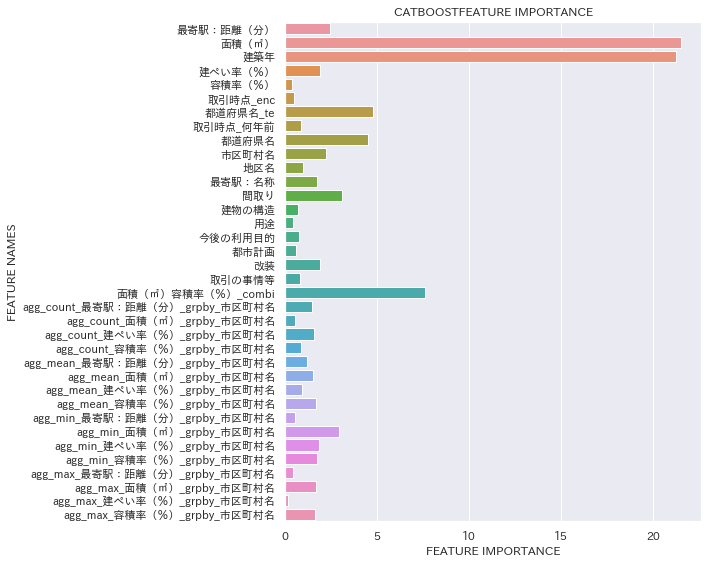

In [58]:
#plot the catboost result
plot_feature_importance(optimised_model.get_feature_importance(),train_x.columns,'CATBOOST')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [59]:
# CatBoost推論
y_pred = optimised_model.predict(test_x)

In [60]:
test_df[TARGET] = y_pred

In [61]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [62]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))